# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


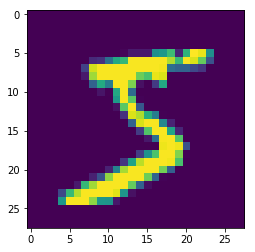

In [3]:
plt.imshow(X_train[0, 0])

In [4]:
input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Defining network architecture

In [5]:
import lasagne
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax
#from lasagne.layers import *

#Input layer (auxilary)
l1 = InputLayer(shape = input_shape,input_var=input_X)
#fully connected layer, that takes input layer and applies 50 neurons to it.
#nonlinearity here is sigmoid as in logistic regression
#you can give a name to each layer (optional)

l2= ConvLayer(l1, 16, 3, flip_filters=False)
l3= PoolLayer(l2, 2)
l4= ConvLayer(l3, 16, 5, flip_filters=False) 
l5= DenseLayer(l4,num_units=150,nonlinearity = lasagne.nonlinearities.leaky_rectify)

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
l_out = DenseLayer(l5,num_units = 10,nonlinearity=lasagne.nonlinearities.softmax)


In [6]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(l_out)

In [7]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(l_out)
print(all_weights)

[W, b, W, b, W, b, W, b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [8]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adamax(loss, all_weights,learning_rate=0.01)

In [9]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [10]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# inputs - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# outputs - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

# Training loop

In [15]:
import time

num_epochs = 4 #amount of passes through the data

batch_size = 50 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 4 took 341.196s
  training loss (in-iteration):		0.001484
  train accuracy:		99.94 %
  validation accuracy:		98.99 %
Epoch 2 of 4 took 355.642s
  training loss (in-iteration):		0.001152
  train accuracy:		99.96 %
  validation accuracy:		99.13 %
Epoch 3 of 4 took 393.801s
  training loss (in-iteration):		0.000980
  train accuracy:		99.97 %
  validation accuracy:		99.10 %
Epoch 4 of 4 took 389.636s
  training loss (in-iteration):		0.000816
  train accuracy:		99.98 %
  validation accuracy:		99.04 %


In [16]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: 80lvl Warlock!")
else:
    print ("We need more magic!")

Final results:
  test accuracy:		99.07 %
Achievement unlocked: 80lvl Warlock!


# Now improve it!

* Moar layers!
* Moar units!
* Different nonlinearities!